In [5]:
import numpy as np
import math
from matplotlib import pyplot as plt

class mlp(object):
    def __init__(self, shape, activate_function, loss, reg_lam=0):
        input_size, hidden_size, output_size = shape

        self.layer = len(shape)
        self.reg_lambda = reg_lam
        self.hidden_size = hidden_size

        self.act = [self.activation(f) for f in activate_function]
        self.derivate = [self.act_deri(f) for f in activate_function]
        self.error = self.loss_function(loss)

        # self.weights = [np.full((input_size, hidden_size), 0.01),
        #                 np.full((hidden_size, output_size), 0.01)]
        self.weights = [np.random.randn(input_size, hidden_size) * 0.01,
                        np.random.randn(hidden_size, output_size) * 0.01]
        self.delta_weights = [np.zeros((input_size, hidden_size)), np.zeros((hidden_size, output_size))]  # single layer
        self.bias = [np.zeros((1, hidden_size)), np.zeros((1, output_size))]
        self.delta_bias = [np.zeros((1, hidden_size)), np.zeros((1, output_size))]  # single layer

    def __call__(self, data, label, lr):
        net_out = self.forward(data)
        loss, _ = self.error(net_out[-1], label)

        accuracy = np.mean(np.argmax(net_out[-1], axis=1) == np.argmax(label, axis=1))

        self.backpropagation(net_out, label)
        self.step(lr)

        return loss, accuracy

    def prediction(self, test_data):
        net_out = self.forward(test_data)
        return np.argmax(net_out[-1], axis=1)

    def forward(self, x):
        # net = [x.copy(), None, None]
        net_out = [x.copy(), None, None]
        for i in range(self.layer - 1):
            net = np.dot(net_out[i], self.weights[i]) + self.bias[i]
            net_out[i + 1] = self.act[i](net)
        return net_out

    def backpropagation(self, net_out, label):
        delta = [None, None]
        y = net_out[-1]
        delta[-1] = self.derivate[-1](y, label)

        for i in np.arange(self.layer - 2, -1, -1):
            self.delta_weights[i] = np.dot(net_out[i].T, delta[i])
            self.delta_bias[i] = np.sum(delta[i], axis=0, keepdims=True)
            if i - 1 > -1:
                delta[i - 1] = np.dot(delta[i], self.weights[i].T) * self.derivate[i - 1](net_out[i])

    def step(self, lr):
        for i in range(self.layer - 1):
            self.weights[i] -= lr * self.delta_weights[i]
            self.bias[i] -= lr * self.delta_bias[i]

    def activation(self, name):
        z = None
        if name == "Sigmoid":  # Sigmoid
            def sigmoid(x):
                z = 1.0 / (1.0 + math.exp(-x))
                return z

            return sigmoid
        elif name == "ReLU":  # ReLU
            def relu(x):
                if np.isscalar(x):
                    z = np.max(x, 0)
                else:
                    zero_aux = np.zeros(x.shape)
                    meta_z = np.stack((x, zero_aux), axis=-1)
                    z = np.max(meta_z, axis=-1)
                return z

            return relu
        elif name == "Softmax":
            def softmax(x):
                exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
                return exp_x / np.sum(exp_x, axis=1, keepdims=True)
            return softmax
        else:
            print("Activation function name invalid.")
            exit(1)

    def act_deri(self, func_name):
        if func_name == 'Sigmoid':
            def sigmoid_derivative(x):
                g = math.exp(-x) / (1.0 + math.exp(-x)) ** 2
                return g

            return sigmoid_derivative
        elif func_name == 'ReLU':
            def relu_derivative(x):
                g = 1 * (x > 0)
                return g

            return relu_derivative
        elif func_name == 'Softmax':  # which is actually softmax cross entropy loss derivative
            def softmax_cross_entropy(x, label):
                g = x - label
                return g
            return softmax_cross_entropy
        else:
            print("Derivate function not found.")
            exit(1)

    def loss_function(self, name):
        # BCEwithLogits
        # L = - d * math.log(1 / (1 + math.exp(-y))) - (1-d) * math.log(1 - 1 / (1 + math.exp(-y)))
        if name == "Cross_Entropy":
            epsilon = 1e-12

            def cross_entropy(y, d):
                y = np.clip(y, epsilon, 1. - epsilon)
                N = y.shape[0]
                L = -np.sum(d * np.log(y + 1e-9)) / N
                return L, 1

            return cross_entropy
        elif name == "MSE":
            def mse(y, d):
                L = 0.5 * (d - y) ** 2
                der = y - d
                return L, der

            return mse
        else:
            print("Loss name invalid")
            exit(1)

In [2]:
def convert_to_one_hot(y, num_classes):
    return np.eye(num_classes)[y]

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Data Processing
data = pd.read_csv('https://archive.ics.uci.edu/static/public/109/data.csv')
X = data.iloc[:, :-1].values  
y = data.iloc[:, -1].values  

scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_onehot = convert_to_one_hot(y, len(np.unique(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Initialization
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = y_onehot.shape[1]
shape = [input_dim, hidden_dim, output_dim]
actvation_function = ['ReLU', 'Softmax']
loss_function = 'Cross_Entropy'
lr = 0.001

### Training

In [6]:
model = mlp(shape, actvation_function, loss_function)

num_epochs = 100
loss_hist = []
accuracy_hist = []
for epoch in range(num_epochs):
    loss, acc = model(X_train, y_train, lr)
    loss_hist.append(loss)
    accuracy_hist.append(acc)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f} | Accuracy: {acc:.4f}')

Epoch [10/100], Loss: 1.0654 | Accuracy: 0.4014
Epoch [20/100], Loss: 0.9455 | Accuracy: 0.8944
Epoch [30/100], Loss: 0.6105 | Accuracy: 0.9718
Epoch [40/100], Loss: 0.3142 | Accuracy: 0.9718
Epoch [50/100], Loss: 0.1807 | Accuracy: 0.9859
Epoch [60/100], Loss: 0.1226 | Accuracy: 0.9930
Epoch [70/100], Loss: 0.0924 | Accuracy: 0.9930
Epoch [80/100], Loss: 0.0742 | Accuracy: 0.9930
Epoch [90/100], Loss: 0.0620 | Accuracy: 0.9930
Epoch [100/100], Loss: 0.0533 | Accuracy: 0.9930


In [7]:
# 评估模型
predictions = model.prediction(X_test)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Accuracy on test set: 100.00%


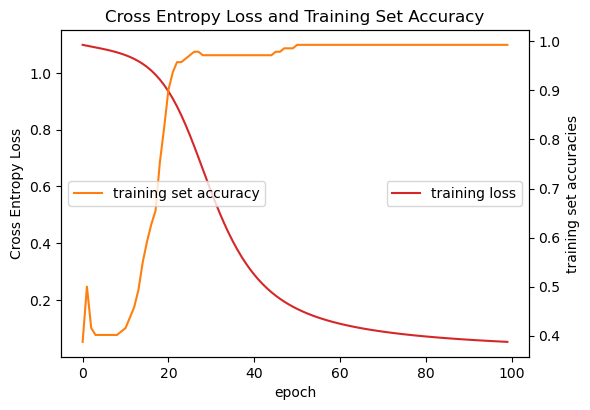

In [9]:
fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.plot(loss_hist, label="training loss", color=color)
ax1.tick_params(axis='y')
ax1.legend(loc="center right")

ax2 = ax1.twinx()  # 创建一个共享同一x轴的第二个y轴
color = 'tab:orange'
ax2.set_ylabel('training set accuracies')  # 我们已经处理了x轴标签
ax2.plot(accuracy_hist, label="training set accuracy", color=color)
ax2.tick_params(axis='y')
ax2.legend(loc="center left")

fig.tight_layout()  # 否则右侧的y轴标签可能会被稍微裁剪
plt.title("Cross Entropy Loss and Training Set Accuracy")
plt.savefig("Wine_Classification_Result.png")

### Effect of learning rate

Test set accuracy for different learning rates:
LR = 0.0001: Accuracy = 0.3889
LR = 0.001: Accuracy = 1.0000
LR = 0.005: Accuracy = 1.0000
LR = 0.01: Accuracy = 1.0000


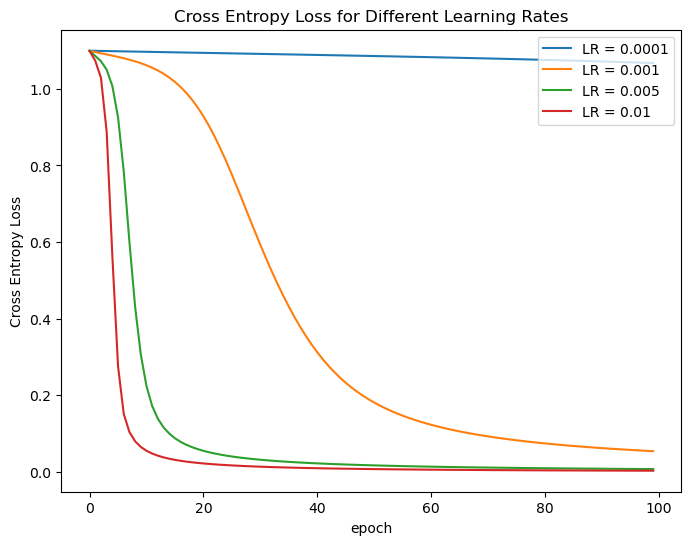

In [16]:
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# (Existing MLP class definition remains unchanged here...)

# Data Processing
data = pd.read_csv('https://archive.ics.uci.edu/static/public/109/data.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_onehot = convert_to_one_hot(y, len(np.unique(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Initialization
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = y_onehot.shape[1]
shape = [input_dim, hidden_dim, output_dim]
activation_function = ['ReLU', 'Softmax']
loss_function = 'Cross_Entropy'

learning_rates = [0.0001, 0.001, 0.005, 0.01]
loss_history = {}
accuracy_history = {}
test_accuracy_results = {}

for lr in learning_rates:
    model = mlp(shape, activation_function, loss_function)
    num_epochs = 100
    loss_hist = []
    accuracy_hist = []
    
    for epoch in range(num_epochs):
        loss, acc = model(X_train, y_train, lr)
        loss_hist.append(loss)
        accuracy_hist.append(acc)
    
    loss_history[lr] = loss_hist
    accuracy_history[lr] = accuracy_hist
    test_predictions = model.prediction(X_test)
    test_accuracy = np.mean(test_predictions == np.argmax(y_test, axis=1))
    test_accuracy_results[lr] = test_accuracy

# Plotting the results
fig, ax1 = plt.subplots(figsize=(8, 6))

for lr, loss_hist in loss_history.items():
    ax1.plot(loss_hist, label=f"LR = {lr}")

ax1.set_xlabel('epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.legend(loc="upper right")
ax1.set_title("Cross Entropy Loss for Different Learning Rates")
plt.savefig("Learning_Rates_Loss_Comparison.png")

print("Test set accuracy for different learning rates:")
for lr, accuracy in test_accuracy_results.items():
    print(f"LR = {lr}: Accuracy = {accuracy:.4f}")

### Effect of hidden layer size

Test set accuracy for different hidden layer sizes:
Hidden Size = 128: Accuracy = 1.0000
Hidden Size = 64: Accuracy = 1.0000
Hidden Size = 32: Accuracy = 1.0000
Hidden Size = 16: Accuracy = 1.0000
Hidden Size = 8: Accuracy = 1.0000
Hidden Size = 4: Accuracy = 1.0000
Hidden Size = 2: Accuracy = 0.7778
Hidden Size = 1: Accuracy = 0.7778


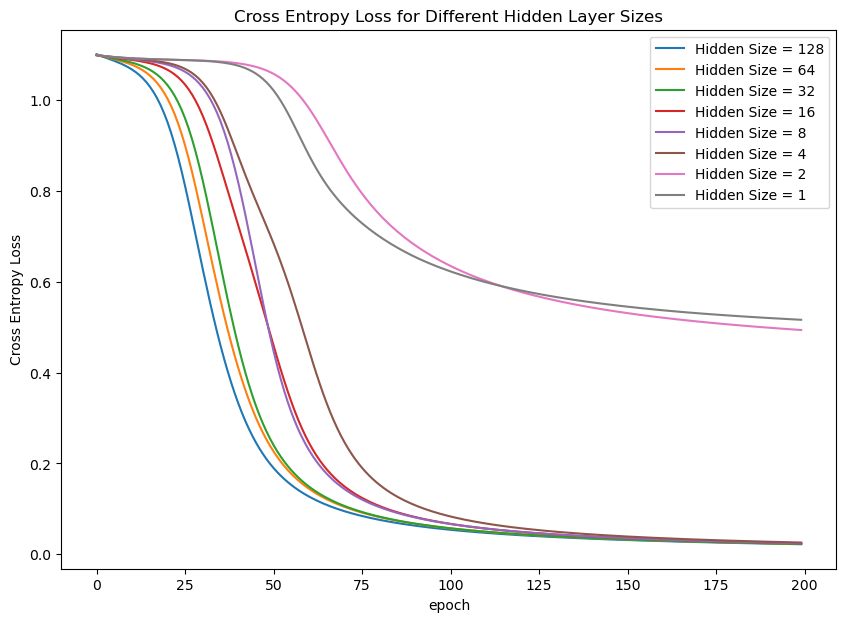

In [31]:
hidden_sizes = [128, 64, 32, 16, 8, 4, 2, 1]
loss_history_sizes = {}
accuracy_history_sizes = {}
test_accuracy_results_sizes = {}

for hidden_size in hidden_sizes:
    # Adjusting the network shape based on the hidden layer size
    shape[1] = hidden_size
    
    model = mlp(shape, activation_function, loss_function)
    num_epochs = 200
    loss_hist = []
    accuracy_hist = []
    
    for epoch in range(num_epochs):
        loss, acc = model(X_train, y_train, 0.001)  # Using a fixed learning rate for this comparison
        loss_hist.append(loss)
        accuracy_hist.append(acc)
    
    loss_history_sizes[hidden_size] = loss_hist
    accuracy_history_sizes[hidden_size] = accuracy_hist
    test_predictions = model.prediction(X_test)
    test_accuracy = np.mean(test_predictions == np.argmax(y_test, axis=1))
    test_accuracy_results_sizes[hidden_size] = test_accuracy

# Plotting the results for different hidden layer sizes
fig, ax1 = plt.subplots(figsize=(10, 7))

for hidden_size, loss_hist in loss_history_sizes.items():
    ax1.plot(loss_hist, label=f"Hidden Size = {hidden_size}")

ax1.set_xlabel('epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.legend(loc="upper right")
ax1.set_title("Cross Entropy Loss for Different Hidden Layer Sizes")
plt.savefig("Hidden_Layer_Sizes_Loss_Comparison.png")

print("Test set accuracy for different hidden layer sizes:")
for hidden_size, accuracy in test_accuracy_results_sizes.items():
    print(f"Hidden Size = {hidden_size}: Accuracy = {accuracy:.4f}")

### Effect of weight initialization

In [75]:
test_accuracy_results_sizes = []
shape = [input_dim, 128, output_dim]

In [76]:
model = mlp(shape, actvation_function, loss_function)

num_epochs = 100
loss_hist_random = []
accuracy_hist_random = []
for epoch in range(num_epochs):
    loss, acc = model(X_train, y_train, lr)
    loss_hist_random.append(loss)
    accuracy_hist_random.append(acc)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f} | Accuracy: {acc:.4f}')

Epoch [10/100], Loss: 1.0775 | Accuracy: 0.3868
Epoch [20/100], Loss: 1.0206 | Accuracy: 0.7642
Epoch [30/100], Loss: 0.8556 | Accuracy: 0.9717
Epoch [40/100], Loss: 0.5976 | Accuracy: 0.9528
Epoch [50/100], Loss: 0.3853 | Accuracy: 0.9623
Epoch [60/100], Loss: 0.2515 | Accuracy: 0.9811
Epoch [70/100], Loss: 0.1771 | Accuracy: 0.9811
Epoch [80/100], Loss: 0.1345 | Accuracy: 0.9811
Epoch [90/100], Loss: 0.1078 | Accuracy: 0.9906
Epoch [100/100], Loss: 0.0898 | Accuracy: 0.9906


In [77]:
test_predictions_random = model.prediction(X_test)
test_accuracy_random = np.mean(test_predictions_random == np.argmax(y_test, axis=1))
test_accuracy_results_sizes.append(test_accuracy_random)
test_accuracy_random

1.0

In [82]:
test_accuracy_results_sizes

[1.0, 0.7777777777777778]

In [86]:
model = mlp(shape, actvation_function, loss_function)

num_epochs = 500
loss_hist_same = []
accuracy_hist_same = []
for epoch in range(num_epochs):
    loss, acc = model(X_train, y_train, lr)
    loss_hist_same.append(loss)
    accuracy_hist_same.append(acc)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f} | Accuracy: {acc:.4f}')

Epoch [10/500], Loss: 1.0737 | Accuracy: 0.5943
Epoch [20/500], Loss: 1.0149 | Accuracy: 0.6509
Epoch [30/500], Loss: 0.9097 | Accuracy: 0.6604
Epoch [40/500], Loss: 0.8164 | Accuracy: 0.6509
Epoch [50/500], Loss: 0.7539 | Accuracy: 0.6698
Epoch [60/500], Loss: 0.7086 | Accuracy: 0.6698
Epoch [70/500], Loss: 0.6736 | Accuracy: 0.6698
Epoch [80/500], Loss: 0.6460 | Accuracy: 0.6792
Epoch [90/500], Loss: 0.6238 | Accuracy: 0.6887
Epoch [100/500], Loss: 0.6057 | Accuracy: 0.6887
Epoch [110/500], Loss: 0.5908 | Accuracy: 0.6887
Epoch [120/500], Loss: 0.5782 | Accuracy: 0.6981
Epoch [130/500], Loss: 0.5675 | Accuracy: 0.6981
Epoch [140/500], Loss: 0.5583 | Accuracy: 0.7075
Epoch [150/500], Loss: 0.5504 | Accuracy: 0.7075
Epoch [160/500], Loss: 0.5435 | Accuracy: 0.7075
Epoch [170/500], Loss: 0.5376 | Accuracy: 0.7075
Epoch [180/500], Loss: 0.5325 | Accuracy: 0.7075
Epoch [190/500], Loss: 0.5279 | Accuracy: 0.7075
Epoch [200/500], Loss: 0.5238 | Accuracy: 0.7075
Epoch [210/500], Loss: 0.5201

In [87]:
test_predictions_same = model.prediction(X_test)
test_accuracy_same = np.mean(test_predictions_same == np.argmax(y_test, axis=1))
test_accuracy_results_sizes.append(test_accuracy_same)
test_accuracy_same

0.7777777777777778

Test set accuracy for different hidden layer sizes:
Hidden Size = 1: Accuracy = 1.0000
Hidden Size = 1: Accuracy = 0.7778


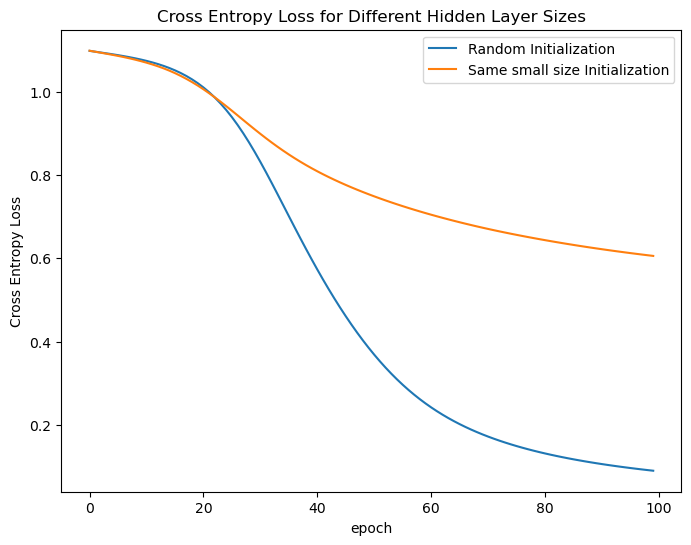

In [85]:
# Plotting the results for different hidden layer sizes
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(loss_hist_random, label="Random Initialization")
ax1.plot(loss_hist_same, label="Same small size Initialization")

ax1.set_xlabel('epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.legend(loc="upper right")
ax1.set_title("Cross Entropy Loss for Different Hidden Layer Sizes")
plt.savefig("Hidden_Layer_Sizes_Loss_Comparison.png")

print("Test set accuracy for different hidden layer sizes:")

for accuracy in test_accuracy_results_sizes:
    print(f"Hidden Size = {hidden_size}: Accuracy = {accuracy:.4f}")

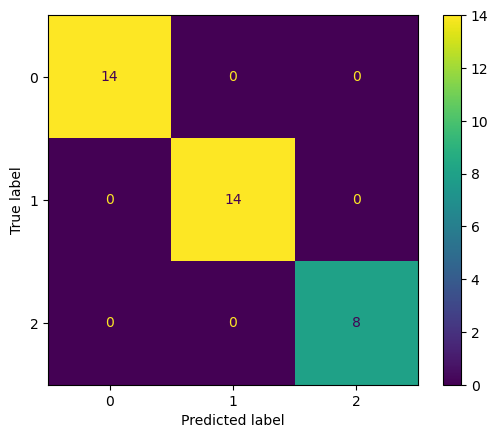

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actual, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("confusion_table.png")